# Classification on a synthetic Titanic Dataset

The titanic is a rather strange topic to use for a machine learning dataset, as there is no way we can re-create and re-crash a future titanic! (Thankfully). But it is a nice dataset that can be used to illustrate some of the concepts of data science and machine learning.

The dataset in use here is a synthetic one created for Kaggle, for precisely this reason

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RANDOM_STATE = 42

## Feature Engineering

Here are the features in the data:

```
survival - Survival (0 = No; 1 = Yes)
class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
name - Name
sex - Sex
age - Age
sibsp - Number of Siblings/Spouses Aboard
parch - Number of Parents/Children Aboard
ticket - Ticket Number
fare - Passenger Fare
cabin - Cabin
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat - Lifeboat (if survived)
body - Body number (if did not survive and body was recovered)
```

Let us systematically write down categorical and numerical columns here, so that we can deal with them properly. We'll also drop some columns, after feature engineering, and we record these as well.

In [3]:
# Constant
cat_cols = ["Sex", "Cabin", "Embarked"]
drop_cols = ["Name", "SibSp", "Parch", "Ticket"]
eventual_cont_cols = ['Age', 'Fare', 'Family']
obj_col = "Survived" # our target
train_df_path = "data/train.csv"
test_df_path = "data/test.csv"

We do some simple manipulations to `Cabin` and `Ticket`, and construct a family number from parents and siblings and spouses. This is not the best feature engineering we can do, see Kaggle for much better, but its about enough to have some fun with Machine Learning models afterwords.

In [4]:
## feature engineering
def feature_engineering(raw_df):
    df = raw_df.copy()
    df["Cabin"] = df["Cabin"].apply(lambda x: x[:1] if x is not np.nan else np.nan)
    df["Ticket"] = df["Ticket"].apply(lambda x: str(x).split()[0])
    df["Family"] = df["SibSp"] + df["Parch"]
    return df

### Preparing the data

Let us load the data, do our feature enginnering, and then drop the unwanted columns, in that order...


In [5]:
print("Loading data...")
df_train = pd.read_csv(train_df_path, index_col="PassengerId")
df_test = pd.read_csv(test_df_path, index_col="PassengerId")

Loading data...


In [6]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [7]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


You will notice that there are 2 dataframes. A **training** dataframe, which contains data which has target labels, and which we will use to train our model. There is also a **testing** dataframe. This one has no labels. You can think of this as future data we want to predict on. Indeed this is the whole setup of machine learning: we learn a model, and wish it to work well on **future** data.

![](images/train-test.png)

Quite often, your boss will give you test data only after your modeling exercise. Or even keep the test data's labels away from you. TKeeping the data AND the labels under lock-and-key, away from you, is indeed what Kaggle does, so that competing models are *tested* on never seen before data, and thus will generalize well to future data.

We'll do feature engineering on both the training data and the test data:

In [8]:
print("Engineering features...")
y = df_train[obj_col]
train_df = feature_engineering(df_train).drop(drop_cols + [obj_col], axis=1)
test_df = feature_engineering(df_test).drop(drop_cols, axis=1)

Engineering features...


Remember that any future data that comes in must be subjected to the same feature engineering, before it can be passed to the model for predictions to be made.

### Dealing with categorical columns

Machine learning models need categories to be encoded as numbers. For these we can use `sklearn` "transformers", which have a simple interface to use. We first encode ALL the data using a transformer by using the `fit` method, and then we transform datasets using the `transform` method.

I do mean ALL. Notice the `allvals = pd.concat([train_df[col], test_df[col]], axis=0)` line. This is to make sure there arent any categorical "levels" in the test set which were not there in the training set.

In [9]:
# cat = ["Sex", "Cabin", "Embarked"]

def to_category(train_df, test_df, cat):
    mappings = {}
    encoders = {}
    for col in cat:
        allvals = pd.concat([train_df[col], test_df[col]], axis=0)
        le = preprocessing.LabelEncoder() # create a transformer
        le.fit(allvals) # fit it on the entire column
        train_df[col] = le.transform(train_df[col]) # transform the train set column separately
        test_df[col] = le.transform(test_df[col]) # transform the validation set column separately
        mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        encoders[col] = le # capture the encoders for later use
    print(mappings)
    return train_df, test_df, encoders

In [10]:
train_df, test_df, encoders = to_category(train_df, test_df, cat_cols)

{'Sex': {'female': 0, 'male': 1}, 'Cabin': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, nan: 8}, 'Embarked': {'C': 0, 'Q': 1, 'S': 2, nan: 3}}


### Final featurization

We impute all null values as 0's for simplicity. A better way would be to selectively impute based on an understanding of why the null occurred.

In [11]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [12]:
train_df.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
PassengerId,,,,,,,
0,1,1,0.00,27.14,2,2,2
1,3,1,0.00,13.35,8,2,0
2,3,1,0.33,71.29,8,2,3
3,3,1,19.00,13.04,8,2,0
4,3,1,25.00,7.76,8,2,0


We do some exploratory Data Analysis (EDA) to understand the trends in our training set.

In [13]:
train_df.describe()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
count,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.106910,0.56114,37.09281,43.870465,5.983550,1.504520,0.852250
std,0.837727,0.49625,19.26607,69.560745,3.023404,0.835899,1.412792
min,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.00000,24.00000,10.020000,2.000000,1.000000,0.000000
50%,2.000000,1.00000,38.00000,24.440000,8.000000,2.000000,0.000000
75%,3.000000,1.00000,53.00000,33.470000,8.000000,2.000000,1.000000
max,3.000000,1.00000,87.00000,744.660000,8.000000,3.000000,17.000000


In [14]:
for col in ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Family']:
    print(col, train_df[col].unique())

Pclass [1 3 2]
Sex [1 0]
Cabin [2 8 0 3 1 4 5 6 7]
Embarked [2 0 1 3]
Family [ 2  0  3  1  4  6  5  9  7 10  8 13 11 17 12 14]


## Training a model

The first thing you must do when you train a model is to leave some data out and use it for validation. The question here is the following: how do you know if your model is any good? If you trained on all the data, you would have no way of checking this.

![](images/train-validate-test.png)

So we leave some data out. The key thing here is this data has labels, so that we can check performance. This left out data is called a **validation set**, or a **development** or **dev** set. It is a good idea to stratify this  splitting using the target: this ensures that the distribution of the target in the training set is similar to that in the validation set. `sklearn` provides the handy-dandy `train_test_split` function to do this:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

### Scaling features

Because we are now training a logistic regression model with multiple features, there is one more thing we must do now. This is to make sure that all numerical variables are on the same scale. Consider here, the ticket price, and the passenger age. The former ranges in the hundreds, the latter in the 10s. Other datasets may have even larger differences.

The "slopes" of these different features will take on different values if the features themselves are so different. For large values features, slopes may become very small, and little numerical errors can mess up your prediction. Thus we like to put all numerical variables on the same scale with mean 0 and standard deviation 1. This "standard scaling" is simple: subtract the mean from the feature and divide by its standard deviation. The interpretation of slopes becomes easier as well.

In a sense you can thing of this as making the space of features "cubical" from 'cuboidal". Algorithms like logistic regression depend implicitly on distance, and this ensures that all the components of the distance are on the same scale.

Scalers in `sklearn` are transformers. We operate them in the same way. (A mild subtlety: `StandardScaler` in `sklearn` expects a feature matrix as input, so even if you are scaling column-by-column as demonstrated below, you must convert columns to a 2-D shape.

In [17]:
from sklearn.preprocessing import StandardScaler
scalers = {}
for k in eventual_cont_cols:
    scalers[k] = StandardScaler().fit(X_train[[k]])
    X_train[k] = scalers[k].transform(X_train[[k]]).flatten()
    X_valid[k] = scalers[k].transform(X_valid[[k]]).flatten()

Notice that we trained the scaler on the training sub-set, NOT the entire original training set. The reason for this is that the validation set we created is to test performance, and we should not **LEAK** any information from that set into the training process. Thus we make sure to use only the mean and standard deviation from the new subset training set.

In [18]:
scalers['Age'].transform(X_train[['Age']]).flatten()

array([-1.98376959, -1.88107166, -1.93242062, ..., -1.83512784,
       -1.86485619, -1.87836908])

### Training the model: training, predictions, and metrics

We are finally ready to train and obtain metrics!

In [19]:
from sklearn.linear_model import LogisticRegression
def fit_model_lr(train_X, train_y, C=1000000, random_state=RANDOM_STATE):
    clf = LogisticRegression(C=C, solver='liblinear')
    clf.fit(train_X, train_y)
    return clf

In [20]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss
)

In [21]:
def get_predictions(clf, X, t=0.5):
    y_proba = clf.predict_proba(X)[:, 1]
    predictions  = 1*(y_proba >= t)
    return y_proba, predictions

In [22]:
def get_metrics(y, ypred, yproba):
    return {
        "accuracy": accuracy_score(y, ypred),
        "cm": confusion_matrix(y, ypred),
        "logloss": log_loss(y, yproba)
    }

In [23]:
# evaluation
def eval_model(clf, X, y, plots=False):
    y_proba, y_pred = get_predictions(clf, X)
    metrics =  get_metrics(y, y_pred, y_proba)
    return metrics

In [24]:
model = fit_model_lr(X_train, y_train)
print(f"Evaluating Model")
train_metrics = eval_model(model, X_train, y_train)
print("Training Set metrics:")
for m in train_metrics:
    print(m, ": \n", train_metrics[m])
print("-------------------------")
valid_metrics = eval_model(model, X_valid, y_valid)
print("Validation Set metrics:")
for m in valid_metrics:
    print(m, ": \n", valid_metrics[m]) 

Evaluating Model
Training Set metrics:
accuracy : 
 0.7662835820895523
cm : 
 [[30231  8110]
 [ 7549 21110]]
logloss : 
 0.5051477041994463
-------------------------
Validation Set metrics:
accuracy : 
 0.7654545454545455
cm : 
 [[14894  3991]
 [ 3749 10366]]
logloss : 
 0.5045599689072664


We see that the performance on the validation set is commensurate with that on the training set. This is a key tenet of machine learning: **dont overfit**, which is the situation in which the performance on the training set exceeds that on the validation set. This means that our model is likely to perform poorly on future dats as indicated by its ppor performance on the validation set.

### Inference

This is the process of making predictions on new data. For example, we have not used our test data here at all, and can consider it to be new data. How do we make predictions on it?

For one, we need to scale it. So we can use our existing scalers to do so:

In [25]:
for k in eventual_cont_cols:
    test_df[k] = scalers[k].transform(test_df[[k]]).flatten()

And once this is done, we can carry out inference.

In [26]:
model.predict(test_df)

array([0, 1, 1, ..., 0, 1, 1])

This process of inference can be carried out on completely new data as well:

In [27]:
data_to_predict = dict(
    Pclass = 1,
    Sex = 'female',
    Age = 40,
    Fare = 250,
    Cabin = 'T',
    Embarked = 'S',
    Family = 0
)
inputX = np.array(list(data_to_predict.values()))
dfnew = pd.DataFrame(inputX.reshape(1,-1), columns=data_to_predict.keys())
dfnew

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,1,female,40,250,T,S,0


First we transform the categoricals in this new data:

In [28]:
df_for_inference = dfnew.copy()
for k in cat_cols:
    df_for_inference[k] = encoders[k].transform(dfnew[k])
df_for_inference

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,1,0,40,250,7,2,0


And then we do the scaling...

In [29]:
for k in eventual_cont_cols:
    df_for_inference[k] = scalers[k].transform(df_for_inference[[k]]).flatten()

In [30]:
df_for_inference

,Pclass,Sex,Age,Fare,Cabin,Embarked,Family
0,1,0,0.152611,2.989973,7,2,-0.601701


Finally we can predict!

In [31]:
model.predict(df_for_inference)

array([1])

## Preventing Overfitting by controlling complexity

You have probably noticed that this scaling, and the model training itself has now occurred on the sub-training set. It does not have to be this way.

After we have ascertained satisfactory performance on our validation set, we can include it for training purposes, and train the model on more data. Ditto for scaling, as we are not leaking anything. This becomes important if we are short of data.

However, if we have enough data this would mean we would be re-raining our model, which is expensive. Thus you might want to just stick with the model trained and scaling done on the subset training data.

This probably sounds a bit confusing: why train on a subset if you were going to train on the full data anyways. You are changing your parameters: slopes and intercept AFTER you ascertained performance with another set of parameters. It's weird.

What we are missing here is that the **validation set** usually has a second purpose: **Model Selection**. We talked earlier about not overfitting. This is typically determined by a complexity "hyperparameter". In logistic regression it is `C`. This hyperparameter is usually fixed on the validation set. Once it is set, it is not changed, even if we now train on the entire training set. This ensures that the complexity of the model is not increased, and that overfitting is avoided.

### The KNN classifier

The kNN classifier works in a very simple way: it looks at the $k$ nearest neighbors on the sub-training set in feature space (see, standard scaling is important here as distance is critical). It asks them: what are they. If a majority of them are 1s, the model predicts a 1 for this new point. The probability of this prediction is estimated by the number in this majority that are 1, divided by $k$.

The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$
 nearest training set neighbors of any point in feature space. Notice that this process divides feature space into regions of one class or the other, since one can simply ask what the $k$ nearest neighbors in the training set are of any given point in feature space.
 
![](images/knn1.png)

The area A in the image above will be classified as red. The area B as blue. C is on the boundary and depends upon the details of the neighbors...

In [32]:
from sklearn.neighbors import KNeighborsClassifier
def fit_model_knn(train_X, train_y, nn=5):
    clf = KNeighborsClassifier(n_neighbors=nn)
    clf.fit(train_X, train_y)
    return clf

Lets see what happens when we choose $k=1$.

On the training set, the 1NN classifier memorizes the training data. It will predict perfectly on the training set, and we wont do too badly on the validation set, especially deep in the regions of feature space where one or the other class dominates. This is because even one neighbor might be enough in those regions. However, the same classifier will do VERY badly near the classification boundaries on the test set, because you will need more than one neighbor to decide with any certainty of the class.

![](images/knn2.png)

This phenomenon, illustrated by the small circles in the figure above is called variance, or overfitting, or under-smoothing. This refers to the notion that we can perfectly remember our training set and will be very sensitive to it. We get so sensitive to the exact location of our training points that even going a bit away renders the model unstable: another mildly closer data point could change the classification. Notice how the model will be very sensitive to the exact distance from those two small circles.

Machine learning, all in all is about making **stable** predictions, and stable this is not.

In [33]:
neighbors = range(1, 9, 2)
for nn in neighbors:
    print(f"Training Model {nn}")
    model = fit_model_knn(X_train, y_train, nn=nn)
    print("Evaluating Model")
    train_info = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_info)
    valid_info = eval_model(model, X_valid, y_valid)
    print("Validation metrics:")
    print(valid_info)
    print('----------------------')

Training Model 1
Evaluating Model
Train metrics:
{'accuracy': 0.9948656716417911, 'cm': array([[38184,   157],
       [  187, 28472]]), 'logloss': 0.17733529278575944}
Validation metrics:
{'accuracy': 0.6927878787878788, 'cm': array([[13860,  5025],
       [ 5113,  9002]]), 'logloss': 10.610852517233068}
----------------------
Training Model 3
Evaluating Model
Train metrics:
{'accuracy': 0.8466567164179104, 'cm': array([[33579,  4762],
       [ 5512, 23147]]), 'logloss': 0.293601921561365}
Validation metrics:
{'accuracy': 0.7356666666666667, 'cm': array([[14670,  4215],
       [ 4508,  9607]]), 'logloss': 3.531710727251312}
----------------------
Training Model 5
Evaluating Model
Train metrics:
{'accuracy': 0.8182388059701493, 'cm': array([[32759,  5582],
       [ 6596, 22063]]), 'logloss': 0.3617280694741077}
Validation metrics:
{'accuracy': 0.7513636363636363, 'cm': array([[15038,  3847],
       [ 4358,  9757]]), 'logloss': 2.1562864350580986}
----------------------
Training Model 7


Notice how the gap between the training accuracy and validation accuracy is highest for $k=1$, with the training accuracy being much higher. This is overfitting. The overfitting persists in all the $k$s considered here, but gets lesser and lesser as we increase $k$.

Now look at the diagram again and see the large circle:

![](images/knn2.png)

Here we have chosen a $k$ too large, and we are averaging/smoothing over too many data points. This is called oversmoothing, underfitting, or bias. The problem here is we took too many neighbors, and so all variation is lost. In the worst case scenarion, when we set $k=N$, we get what is called a **base-rate classifier**, where we simply pick the majority class at all points in feature space.

## Finding the model with the correct complexity $k$

As you have probably guessed by now, this is easily done on the validation set, and provides the main use of validation sets. This "best model" can then be used with the test set to predict future performance...

In [42]:
import uuid
run_id = uuid.uuid4()
info = []
neighbors = range(1, 75, 2)
models_knn = {}
for nn in neighbors:
    run_id = uuid.uuid4()
    print(f"Training Model {nn}")
    model = fit_model_knn(X_train, y_train, nn=nn)
    models_knn[run_id] = model
    print("Evaluating Model")
    train_info = eval_model(model, X_train, y_train)
    print("Train metrics:")
    print(train_info)
    train_info['data'] = 'train'
    train_info['nn'] = nn
    train_info['run_id'] = run_id
    info.append(train_info)
    valid_info = eval_model(model, X_valid, y_valid)
    print("Validation metrics:")
    print(valid_info)
    valid_info['data'] = 'valid'
    valid_info['nn'] = nn
    valid_info['run_id'] = run_id
    info.append(valid_info)
    print('----------------------')

Training Model 1
Evaluating Model
Train metrics:
{'accuracy': 0.9948656716417911, 'cm': array([[38184,   157],
       [  187, 28472]]), 'logloss': 0.17733529278575944}
Validation metrics:
{'accuracy': 0.6927878787878788, 'cm': array([[13860,  5025],
       [ 5113,  9002]]), 'logloss': 10.610852517233068}
----------------------
Training Model 3
Evaluating Model
Train metrics:
{'accuracy': 0.8466567164179104, 'cm': array([[33579,  4762],
       [ 5512, 23147]]), 'logloss': 0.293601921561365}
Validation metrics:
{'accuracy': 0.7356666666666667, 'cm': array([[14670,  4215],
       [ 4508,  9607]]), 'logloss': 3.531710727251312}
----------------------
Training Model 5
Evaluating Model
Train metrics:
{'accuracy': 0.8182388059701493, 'cm': array([[32759,  5582],
       [ 6596, 22063]]), 'logloss': 0.3617280694741077}
Validation metrics:
{'accuracy': 0.7513636363636363, 'cm': array([[15038,  3847],
       [ 4358,  9757]]), 'logloss': 2.1562864350580986}
----------------------
Training Model 7


In [43]:
resudf = pd.DataFrame.from_records(info).set_index('run_id')
resudf

,accuracy,cm,logloss,data,nn
run_id,,,,,
d9914f84-dc16-4907-9575-92e3be1c9abb,0.994866,"[[38184, 157], [187, 28472]]",0.177335,train,1
d9914f84-dc16-4907-9575-92e3be1c9abb,0.692788,"[[13860, 5025], [5113, 9002]]",10.610853,valid,1
f9f5c22e-3b38-42f2-bfc5-47ff16b3deae,0.846657,"[[33579, 4762], [5512, 23147]]",0.293602,train,3
f9f5c22e-3b38-42f2-bfc5-47ff16b3deae,0.735667,"[[14670, 4215], [4508, 9607]]",3.531711,valid,3
4923c62a-afcd-4a73-8b0d-a4d76a64598a,0.818239,"[[32759, 5582], [6596, 22063]]",0.361728,train,5
...,...,...,...,...,...
9a7e4395-adb5-4023-9090-5c41751bf8b4,0.772576,"[[15272, 3613], [3892, 10223]]",0.484257,valid,69
a822b30f-d832-4809-9b3a-d14ec38e34e1,0.779821,"[[31233, 7108], [7644, 21015]]",0.470779,train,71
a822b30f-d832-4809-9b3a-d14ec38e34e1,0.772061,"[[15261, 3624], [3898, 10217]]",0.484254,valid,71


In [44]:
resudf.to_csv("results/results_knn.csv", header=True)

In [45]:
resudf[resudf.data=='valid'].sort_values('accuracy', ascending=False)

,accuracy,cm,logloss,data,nn
run_id,,,,,
c64842f0-42a8-4791-9d2b-584598642320,0.773606,"[[15285, 3600], [3871, 10244]]",0.496235,valid,51
9a703b05-7c32-4569-975a-f0c8f9076700,0.773424,"[[15280, 3605], [3872, 10243]]",0.500275,valid,49
4b48862d-eb80-4c94-b393-2786e873b9e0,0.773303,"[[15278, 3607], [3874, 10241]]",0.495259,valid,53
693df9b4-4f25-4354-80df-d64d6bf78974,0.773273,"[[15279, 3606], [3876, 10239]]",0.487750,valid,61
9091fd19-c1a3-4eba-841f-2fee9ca01551,0.773273,"[[15287, 3598], [3884, 10231]]",0.487728,valid,59
6b0f72c5-3ee5-422e-9c0b-44e9b90b3c6b,0.773242,"[[15275, 3610], [3873, 10242]]",0.512470,valid,45
160604d6-4fa6-450e-9231-d2a594432e44,0.773061,"[[15276, 3609], [3880, 10235]]",0.486357,valid,63
3ddf7e33-251c-4d6a-8fdc-f78a63340a49,0.773030,"[[15288, 3597], [3893, 10222]]",0.519458,valid,41
bac7c45c-e7de-40c0-b565-81537a4ff5ee,0.772970,"[[15275, 3610], [3882, 10233]]",0.486345,valid,65


In [46]:
results_plot = resudf[['data', 'nn', 'accuracy', 'logloss']]
rptrain = results_plot[results_plot.data=='train']
rpvalid = results_plot[results_plot.data=='valid']

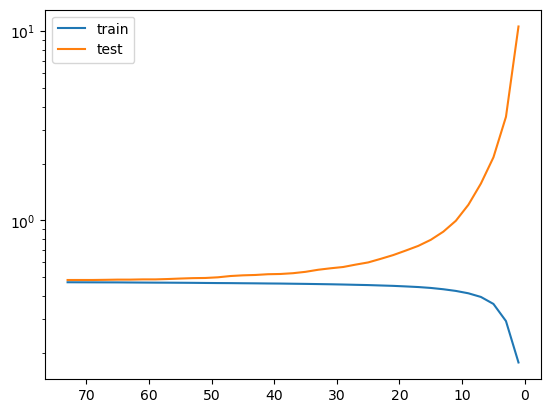

In [47]:
plt.plot(rptrain.nn, rptrain.logloss, label="train")
plt.plot(rpvalid.nn, rpvalid.logloss, label="test")
plt.legend()
plt.yscale('log')
plt.gca().invert_xaxis()

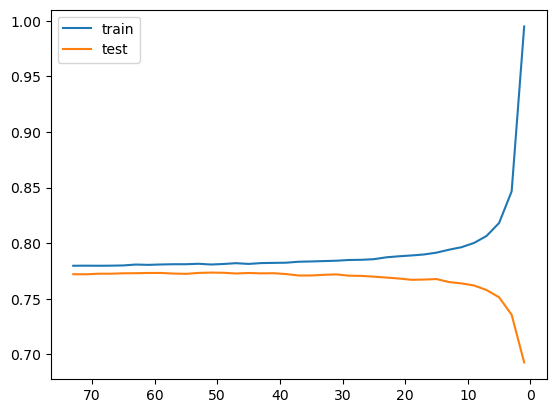

In [48]:
plt.plot(rptrain.nn, rptrain.accuracy, label="train")
plt.plot(rpvalid.nn, rpvalid.accuracy, label="test")
plt.legend()
plt.gca().invert_xaxis()

In [49]:
bestuuid = resudf[resudf.data=='valid'].sort_values('accuracy', ascending=False).iloc[0].name
bestuuid

UUID('c64842f0-42a8-4791-9d2b-584598642320')

In [50]:
bestmodel = models_knn[bestuuid]

In [51]:
bestmodel.predict(test_df)

array([0, 1, 1, ..., 0, 1, 1])

In [52]:
bestmodel.predict(df_for_inference)

array([0])